# pycbf - Basic example

This notebook roughly simulates channel data and beamforms it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from pycbf import gpu, cpu
from scipy.signal import hilbert

## Generating channel data

In [2]:
# channel data parameters
fc = 5E6        # centerfrequency of plane wave excitation [Hz]
fs =  6 * fc    # sampling frequency [Hz]
c = 1540        # speed of sound [m/s]
lam = c/fc      # wavelength [m]

nele = 64       # number of elements in probe
dele = lam      # probe spacing [m]

# locations of elements
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele, indexing='ij')
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# reconstruction grid
xgrid = dele*(np.arange(0, nele, 1/2) - (nele-1)/2)
ygrid = 0
zgrid = np.arange(1*lam, nele*dele, lam/8)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
grid = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

ex_grid = 1E3*np.array([xgrid[0], xgrid[-1], zgrid[-1], zgrid[0]])

## Calculate the full synthetic aperture using a point-like assumption

In [3]:
# location of point scatterer
pointa = np.array([[nele*dele/8, 0, nele*dele/4]])
pointb = np.array([[-nele*dele/7, 0, nele*dele/3]])
pointc = np.array([[0, 0, 2*nele*dele/7]])

rf = 0
for point in [pointa, pointb, pointc]:
    # time delays between each element and the point
    tau = np.linalg.norm(eles - point, axis=-1)/c

    # generate all (realtive) time points for each pulse
    tmax = 2*np.sqrt((dele * (nele-1))**2 + (nele*dele)**2)/c
    t = np.arange(0, tmax, 1/fs)

    # calculate all delay tabs
    T = t[None,None,:] - (tau[:,None,None] + tau[None,:,None])

    # make rf data from tabs
    rf += sig.gausspulse(t=T, fc=fc, bw=0.75)

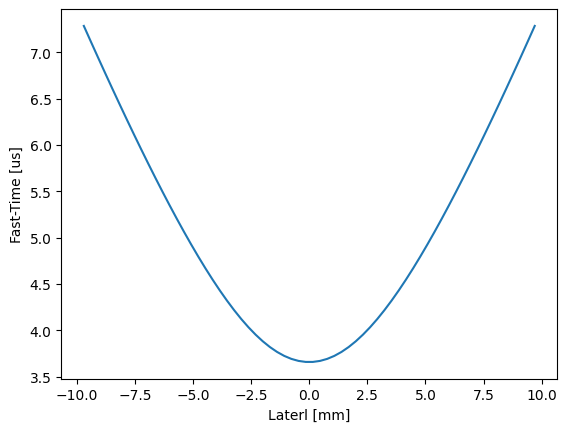

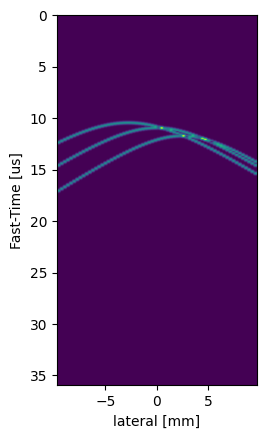

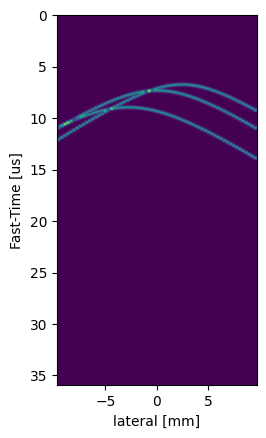

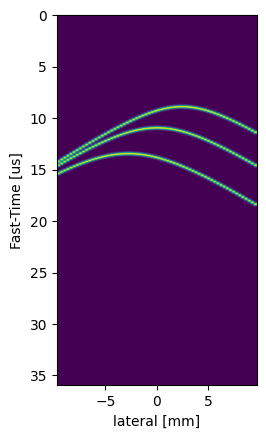

In [4]:
# plot delay tabs
plt.figure()
plt.plot(1E3*xele, 1E6*tau.flatten())
plt.xlabel("Laterl [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

env = np.abs(sig.hilbert(rf, axis=-1))
plt.figure()
plt.imshow(env[0,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[nele//2,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

plt.figure()
plt.imshow(env[-1,:,:].T, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

## Calculate delay tabs and apodizations

In [5]:
dXvec = grid[None,:,:] - eles[:,None,:]
fnum = 1
tautxrx = np.linalg.norm(dXvec, axis=-1)/c
apodrect = np.abs(dXvec[:,:,0]) - dXvec[:,:,2]/(2*fnum) < 0

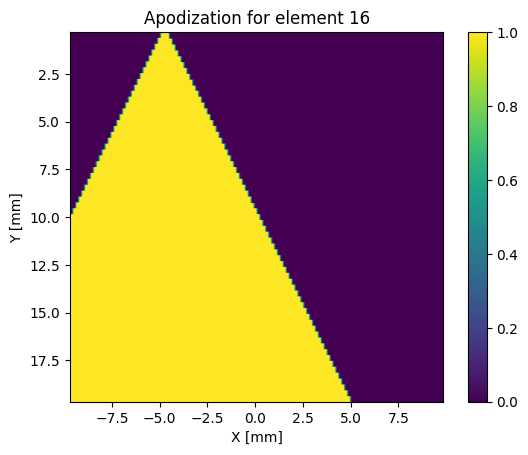

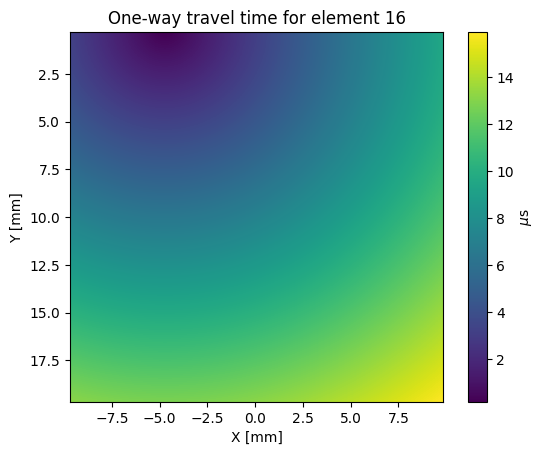

In [6]:
plt.figure()
plt.imshow(apodrect[16].reshape(Xgrid.shape[0], Xgrid.shape[-1]).T, extent=ex_grid)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("Apodization for element 16")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(
    1E6*tautxrx[16].reshape(Xgrid.shape[0], Xgrid.shape[-1]).T, 
    extent=ex_grid
)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("One-way travel time for element 16")
plt.colorbar(label='$\\mu$s')
plt.show()

In [7]:
bmfrm_gpu = gpu.TabbedDAS(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t)
)

bmfrm_cpu = cpu.TabbedDAS(
    tautx=tautxrx,
    taurx=tautxrx,
    apodtx=apodrect,
    apodrx=apodrect,
    t0=t[0],
    dt = t[1]-t[0],
    nt = len(t)
)

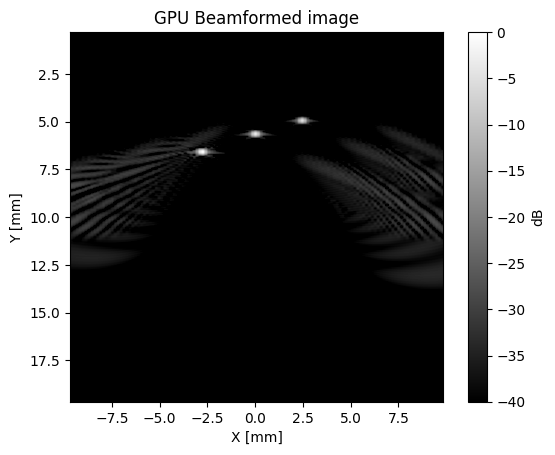

In [8]:
im_gpu = bmfrm_gpu(rf).reshape(Xgrid.shape).T.squeeze()
env_gpu = np.abs(hilbert(im_gpu, axis=0))
logged = 20*np.log10(env_gpu/np.max(env_gpu))

plt.figure()
plt.imshow(
    logged,
    extent=ex_grid,
    cmap='grey',
    vmin=-40, vmax=0
)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("GPU Beamformed image")
plt.colorbar(label='dB')
plt.show()

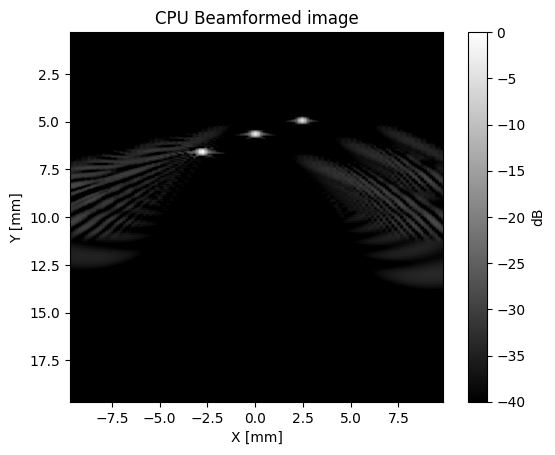

In [9]:
im_cpu = bmfrm_cpu(rf).reshape(Xgrid.shape).T.squeeze()
env_cpu = np.abs(hilbert(im_cpu, axis=0))
logged = 20*np.log10(env_cpu/np.max(env_cpu))

plt.figure()
plt.imshow(
    logged,
    extent=ex_grid,
    cmap='grey',
    vmin=-40, vmax=0
)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("CPU Beamformed image")
plt.colorbar(label='dB')
plt.show()

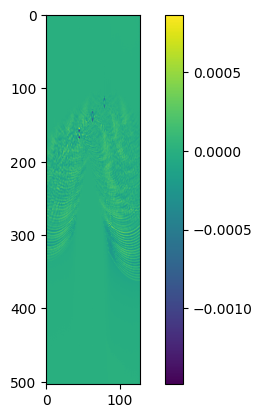

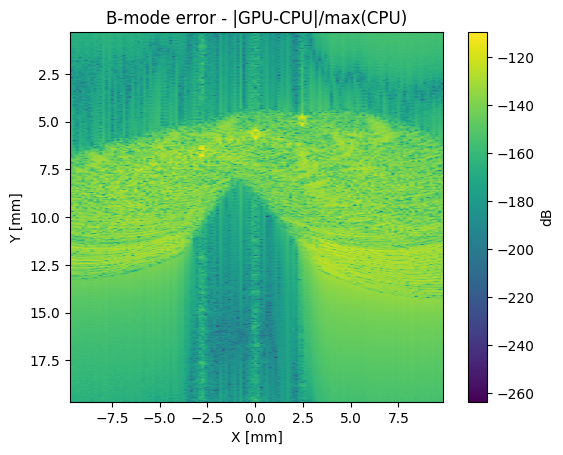

In [10]:
plt.figure()
plt.imshow(env_gpu-env_cpu)
plt.colorbar()
plt.show()
err_norm = np.abs(env_gpu-env_cpu)/np.max(env_cpu)

plt.figure()
plt.imshow(20*np.log10(err_norm),
    extent=ex_grid)
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.colorbar(label='dB')
plt.title("B-mode error - |GPU-CPU|/max(CPU)")
plt.show()